In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
class Stitcher:
    def __init__(self):
        pass

    def stitch(self, imgs, blending_mode="linearBlending", ratio=0.75):
        """
        The main method to stitch images
        """
        if len(imgs) != 3:
            raise ValueError("Three images are required for stitching.")

        img_left, img_mid, img_right = imgs

        # Stitch the left and middle images
        warp_left_mid = self._stitch_two_images([img_left, img_mid], blending_mode, ratio)
        warp_left_mid = np.clip(warp_left_mid, 0, 255).astype(np.uint8)
        warp_left_mid_cv2 = cv2.cvtColor(warp_left_mid, cv2.COLOR_RGB2BGR)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2BGR)
        # Stitch the result with the right image
        warp_img = self._stitch_two_images([warp_left_mid_cv2, img_right], blending_mode, ratio)

        return warp_img

    def _stitch_two_images(self, imgs, blending_mode, ratio):
        """
        Helper method to stitch two images
        """
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        print("Left img size (", hl, "*", wl, ")")
        print("Right img size (", hr, "*", wr, ")")

        # Step1 - extract the keypoints and features by SIFT detector and descriptor
        print("Step1 - Extract the keypoints and features by SIFT detector and descriptor...")
        kps_l, features_l = self.detectAndDescribe(img_left)
        kps_r, features_r = self.detectAndDescribe(img_right)

        # Step2 - extract the match point with threshold (David Lowe's ratio test)
        print("Step2 - Extract the match point with threshold (David Lowe's ratio test)...")
        matches_pos = self.matchKeyPoint(kps_l, kps_r, features_l, features_r, ratio)
        print("The number of matching points:", len(matches_pos))

        # Step2 - draw the img with matching point and their connection line
        self.drawMatches([img_left, img_right], matches_pos)

        # Step3 - fit the homography model with RANSAC algorithm
        print("Step3 - Fit the best homography model with RANSAC algorithm...")
        HomoMat = self.fitHomoMat(matches_pos)

        # Step4 - Warp image to create panoramic image
        print("Step4 - Warp image to create panoramic image...")
        warp_img = self.warp([img_left, img_right], HomoMat, blending_mode)

        return warp_img

    def detectAndDescribe(self, img):
        '''
        The Detector and Descriptor
        '''
        # SIFT detector and descriptor
        sift = cv2.SIFT_create()
        kps, features = sift.detectAndCompute(img,None)

        return kps, features

    def matchKeyPoint(self, kps_l, kps_r, features_l, features_r, ratio):
        '''
            Match the Keypoints beteewn two image
        '''
        Match_idxAndDist = [] # min corresponding index, min distance, seccond min corresponding index, second min distance
        for i in range(len(features_l)):
            min_IdxDis = [-1, np.inf]  # record the min corresponding index, min distance
            secMin_IdxDis = [-1 ,np.inf]  # record the second corresponding min index, min distance
            for j in range(len(features_r)):
                dist = np.linalg.norm(features_l[i] - features_r[j])
                if (min_IdxDis[1] > dist):
                    secMin_IdxDis = np.copy(min_IdxDis)
                    min_IdxDis = [j , dist]
                elif (secMin_IdxDis[1] > dist and secMin_IdxDis[1] != min_IdxDis[1]):
                    secMin_IdxDis = [j, dist]

            Match_idxAndDist.append([min_IdxDis[0], min_IdxDis[1], secMin_IdxDis[0], secMin_IdxDis[1]])

        # ratio test as per Lowe's paper
        goodMatches = []
        for i in range(len(Match_idxAndDist)):
            if (Match_idxAndDist[i][1] <= Match_idxAndDist[i][3] * ratio):
                goodMatches.append((i, Match_idxAndDist[i][0]))

        goodMatches_pos = []
        for (idx, correspondingIdx) in goodMatches:
            psA = (int(kps_l[idx].pt[0]), int(kps_l[idx].pt[1]))
            psB = (int(kps_r[correspondingIdx].pt[0]), int(kps_r[correspondingIdx].pt[1]))
            goodMatches_pos.append([psA, psB])

        return goodMatches_pos

    def drawMatches(self, imgs, matches_pos):
        '''
            Draw the match points img with keypoints and connection line
        '''

        # initialize the output visualization image
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
        vis[0:hl, 0:wl] = img_left
        vis[0:hr, wl:] = img_right

        # Draw the match
        for (img_left_pos, img_right_pos) in matches_pos:

                pos_l = img_left_pos
                pos_r = img_right_pos[0] + wl, img_right_pos[1]
                cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
                cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
                cv2.line(vis, pos_l, pos_r, (255, 0, 0), 1)

        # return the visualization
        plt.figure(4)
        plt.title("img with matching points")
        plt.imshow(vis[:,:,::-1])
        #cv2.imwrite("Feature matching img/matching.jpg", vis)

        return vis

    def fitHomoMat(self, matches_pos):
        '''
            Fit the best homography model with RANSAC algorithm - noBlending、linearBlending、linearBlendingWithConstant
        '''
        dstPoints = [] # i.e. left image(destination image)
        srcPoints = [] # i.e. right image(source image)
        for dstPoint, srcPoint in matches_pos:
            dstPoints.append(list(dstPoint))
            srcPoints.append(list(srcPoint))
        dstPoints = np.array(dstPoints)
        srcPoints = np.array(srcPoints)

        homography = Homography()

        # RANSAC algorithm, selecting the best fit homography
        NumSample = len(matches_pos)
        threshold = 5.0
        NumIter = 8000
        NumRamdomSubSample = 4
        MaxInlier = 0
        Best_H = None

        for run in range(NumIter):
            SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample) # get the Index of ramdom sampling
            H = homography.solve_homography(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])

            # find the best Homography have the the maximum number of inlier
            NumInlier = 0
            for i in range(NumSample):
                if i not in SubSampleIdx:
                    concateCoor = np.hstack((srcPoints[i], [1])) # add z-axis as 1
                    dstCoor = H @ concateCoor.T # calculate the coordination after transform to destination img
                    if dstCoor[2] <= 1e-8: # avoid divide zero number, or too small number cause overflow
                        continue
                    dstCoor = dstCoor / dstCoor[2]
                    if (np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold):
                        NumInlier = NumInlier + 1
            if (MaxInlier < NumInlier):
                MaxInlier = NumInlier
                Best_H = H

        print("The Number of Maximum Inlier:", MaxInlier)

        return Best_H

    def warp(self, imgs, HomoMat, blending_mode):
        '''
           Warp image to create panoramic image
           There are three different blending method - noBlending、linearBlending、linearBlendingWithConstant
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        stitch_img = np.zeros( (max(hl, hr), wl + wr, 3), dtype="int") # create the (stitch)big image accroding the imgs height and width

        if (blending_mode == "noBlending"):
            stitch_img[:hl, :wl] = img_left

        # Transform Right image(the coordination of right image) to destination iamge(the coordination of left image) with HomoMat
        inv_H = np.linalg.inv(HomoMat)
        for i in range(stitch_img.shape[0]):
            for j in range(stitch_img.shape[1]):
                coor = np.array([j, i, 1])
                img_right_coor = inv_H @ coor # the coordination of right image
                img_right_coor /= img_right_coor[2]

                # you can try like nearest neighbors or interpolation
                y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1])) # y for width, x for height


                # if the computed coordination not in the (hegiht, width) of right image, it's not need to be process
                if (x < 0 or x >= hr or y < 0 or y >= wr):
                    continue
                # else we need the tranform for this pixel
                stitch_img[i, j] = img_right[x, y]


        # create the Blender object to blending the image
        blender = Blender()
        if (blending_mode == "linearBlending"):
            stitch_img = blender.linearBlending([img_left, stitch_img])
        elif (blending_mode == "linearBlendingWithConstant"):
            stitch_img = blender.linearBlendingWithConstantWidth([img_left, stitch_img])

        # remove the black border
        stitch_img = self.removeBlackBorder(stitch_img)

        return stitch_img

    def removeBlackBorder(self, img):
        '''
        Remove img's the black border
        '''
        h, w = img.shape[:2]
        reduced_h, reduced_w = h, w
        # right to left
        for col in range(w - 1, -1, -1):
            all_black = True
            for i in range(h):
                if (np.count_nonzero(img[i, col]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_w = reduced_w - 1

        # bottom to top
        for row in range(h - 1, -1, -1):
            all_black = True
            for i in range(reduced_w):
                if (np.count_nonzero(img[row, i]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_h = reduced_h - 1

        return img[:reduced_h, :reduced_w]

In [3]:
class Blender:
    def linearBlending(self, imgs):
        '''
        linear Blending(also known as Feathering)
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")

        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1

        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1

        # Plot the overlap mask
        plt.figure(21)
        plt.title("overlap_mask")
        plt.imshow(overlap_mask.astype(int), cmap="gray")

        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr):
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j

            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue

            decrease_step = 1 / (maxIdx - minIdx)
            for j in range(minIdx, maxIdx + 1):
                alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))



        linearBlending_img = np.copy(img_right)
        linearBlending_img[:hl, :wl] = np.copy(img_left)
        # linear blending
        for i in range(hr):
            for j in range(wr):
                if ( np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlending_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]

        return linearBlending_img
    def linearBlendingWithConstantWidth(self, imgs):
        '''
        linear Blending with Constat Width, avoiding ghost region
        # you need to determine the size of constant with
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        constant_width = 3 # constant width

        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1

        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1

        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr):
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j

            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue

            decrease_step = 1 / (maxIdx - minIdx)

            # Find the middle line of overlapping regions, and only do linear blending to those regions very close to the middle line.
            middleIdx = int((maxIdx + minIdx) / 2)

            # left
            for j in range(minIdx, middleIdx + 1):
                if (j >= middleIdx - constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 1
            # right
            for j in range(middleIdx + 1, maxIdx + 1):
                if (j <= middleIdx + constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 0


        linearBlendingWithConstantWidth_img = np.copy(img_right)
        linearBlendingWithConstantWidth_img[:hl, :wl] = np.copy(img_left)
        # linear blending with constant width
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlendingWithConstantWidth_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]

        return linearBlendingWithConstantWidth_img

In [4]:
class Homography:
    def solve_homography(self, P, m):
        """
        Solve homography matrix

        Args:
            P:  Coordinates of the points in the original plane,
            m:  Coordinates of the points in the target plane


        Returns:
            H: Homography matrix
        """
        try:
            A = []
            for r in range(len(P)):
                #print(m[r, 0])
                A.append([-P[r,0], -P[r,1], -1, 0, 0, 0, P[r,0]*m[r,0], P[r,1]*m[r,0], m[r,0]])
                A.append([0, 0, 0, -P[r,0], -P[r,1], -1, P[r,0]*m[r,1], P[r,1]*m[r,1], m[r,1]])

            u, s, vt = np.linalg.svd(A) # Solve s ystem of linear equations Ah = 0 using SVD
            # pick H from last line of vt
            H = np.reshape(vt[8], (3,3))
            # normalization, let H[2,2] equals to 1
            H = (1/H.item(8)) * H
        except:
            print("Error occur!")

        return H


In [10]:
!ls

IMG_13.jpg  IMG_14.jpg	IMG_15.jpg  img_1.JPG  img_2.JPG  img_3.JPG  panorama2.jpg  sample_data


Left img size ( 775 * 904 )
Right img size ( 794 * 620 )
Step1 - Extract the keypoints and features by SIFT detector and descriptor...
Step2 - Extract the match point with threshold (David Lowe's ratio test)...
The number of matching points: 1139
Step3 - Fit the best homography model with RANSAC algorithm...
The Number of Maximum Inlier: 1100
Step4 - Warp image to create panoramic image...
Left img size ( 794 * 1369 )
Right img size ( 824 * 667 )
Step1 - Extract the keypoints and features by SIFT detector and descriptor...
Step2 - Extract the match point with threshold (David Lowe's ratio test)...
The number of matching points: 986
Step3 - Fit the best homography model with RANSAC algorithm...
The Number of Maximum Inlier: 936
Step4 - Warp image to create panoramic image...


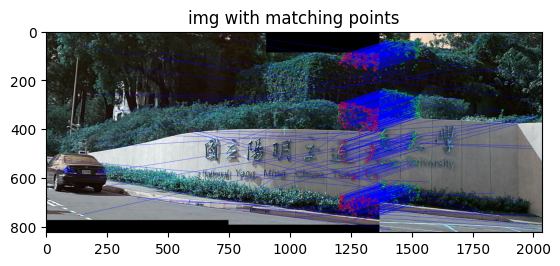

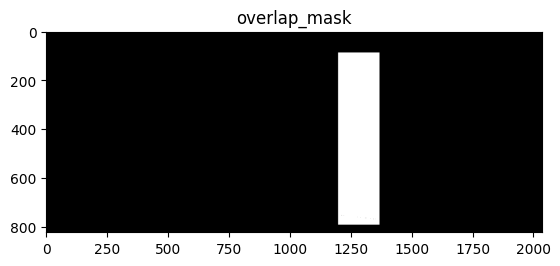

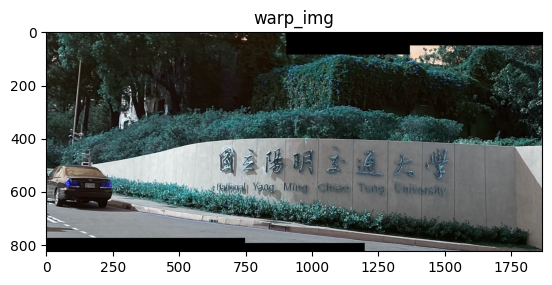

In [13]:
if __name__ == "__main__":
  #/content/IMG_0806.JPG
    fileNameList = [('IMG_13.jpg', 'IMG_14.jpg','IMG_15.jpg')]
    for fname1, fname2, fname3 in fileNameList:
        # Read the img file
        # src_path = "img/"
        fileName1 = fname1
        fileName2 = fname2
        fileName3 = fname3
        img_left = cv2.imread(fileName1)
        img_mid = cv2.imread(fileName2)
        img_right = cv2.imread(fileName3)

        # The stitch object to stitch the image
        blending_mode = "linearBlending" # three mode - noBlending、linearBlending、linearBlendingWithConstant
        stitcher = Stitcher()
        panorama = stitcher.stitch([img_left, img_mid, img_right])

        # plot the stitched image
        plt.figure(13)
        plt.title("warp_img")
        plt.imshow(panorama[:,:,::-1].astype(int))

        # save the stitched iamge
        saveFilePath = "panorama2.jpg"
        cv2.imwrite(saveFilePath, panorama)

In [14]:
panorama = np.clip(panorama, 0, 255).astype(np.uint8)
panorama = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)

In [15]:
saveFilePath = "交通大學.jpg"
cv2.imwrite(saveFilePath, panorama)

True